# Name: Mohamed Bakrey Mahmoud.
Company: CodeClause
Socend Project: Fraud Detection

# Introduction 

Paysim synthetic data set for mobile financial transactions. Each step represents an hour of simulation. This data set has been scaled down by 1/4 of the original data set presented in the research paper “PaySim: A Mobile Money Simulator for Fraud Detection.

## Import Library

In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import seaborn as sns
sns.set_style("dark")

from sklearn import preprocessing
from scipy.stats import skew, boxcox
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

## Read Dataset

In [3]:
df=pd.read_csv("/content/PS_20174392719_1491204439457_log.csv")
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0.0,0.0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0.0,0.0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0.0,0.0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0.0,0.0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0.0,0.0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219765 entries, 0 to 219764
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            219765 non-null  int64  
 1   type            219765 non-null  object 
 2   amount          219765 non-null  float64
 3   nameOrig        219765 non-null  object 
 4   oldbalanceOrg   219765 non-null  float64
 5   newbalanceOrig  219764 non-null  float64
 6   nameDest        219764 non-null  object 
 7   oldbalanceDest  219764 non-null  float64
 8   newbalanceDest  219764 non-null  float64
 9   isFraud         219764 non-null  float64
 10  isFlaggedFraud  219764 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 18.4+ MB


In [11]:
# Count the values of columns 'isFraud'
df['isFraud'].value_counts()

0.0    219609
1.0       155
Name: isFraud, dtype: int64

PAYMENT     79861
CASH_OUT    73992
CASH_IN     45648
TRANSFER    18450
DEBIT        1814
Name: type, dtype: int64
****************************************************************************


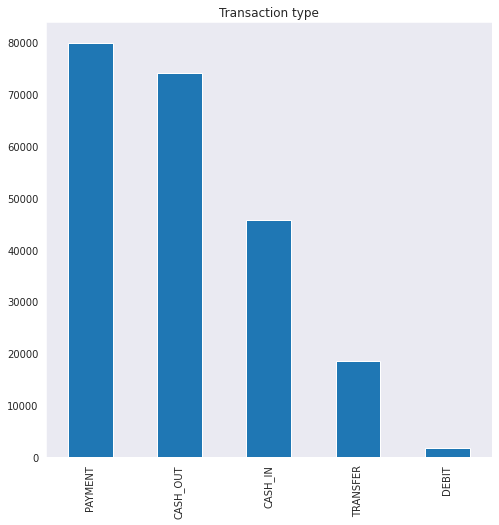

In [12]:
print(df.type.value_counts())
print("****************************************************************************")
f, ax = plt.subplots(1, 1, figsize=(8, 8))
df.type.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(8,8))
plt.show()

There are 2 flags that stand out to me and it's interesting to look at: is fraud and isFlaggedFraud column. From the hypothesis, isFraud is the indicator that indicates the actual fraud transactions whereas isFlaggedFraud is what the system prevents the transaction due to some thresholds being triggered.


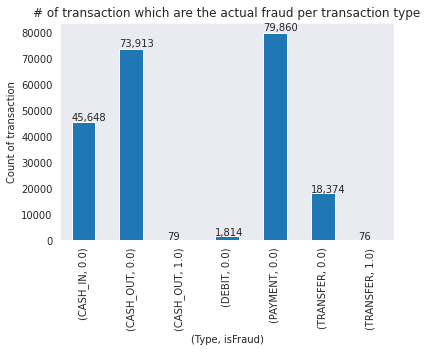

In [6]:
ax = df.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

So it looks the simulation can flag only 16 transfer transactions as fraud. Let's look at those records and compare them with the records which the system cannot catch'em.

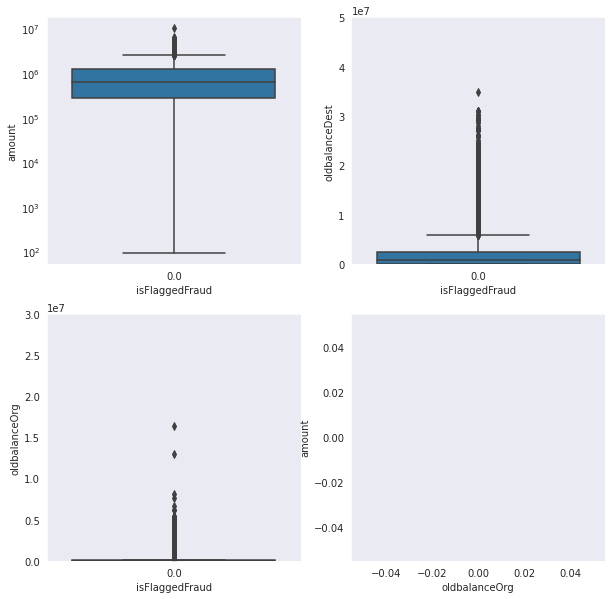

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
tmp = df.loc[(df.type == 'TRANSFER'), :]

a = sns.boxplot(x = 'isFlaggedFraud', y = 'amount', data = tmp, ax=axs[0][0])
axs[0][0].set_yscale('log')
b = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceDest', data = tmp, ax=axs[0][1])
axs[0][1].set(ylim=(0, 0.5e8))
c = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceOrg', data=tmp, ax=axs[1][0])
axs[1][0].set(ylim=(0, 3e7))
d = sns.regplot(x = 'oldbalanceOrg', y = 'amount', data=tmp.loc[(tmp.isFlaggedFraud ==1), :], ax=axs[1][1])
plt.show()

It looks like the isFlaggedFraud variable relies on oldbalanceDest, which is 0, and some threshold on the amount variable.

# 2. Modeling

In [43]:
from statsmodels.tools import categorical

# 1. Keep only interested transaction type ('TRANSFER', 'CASH_OUT')
# 2. Drop some columns
# 3. Convert categorical variables to numeric variable
tmp = df.loc[(df['type'].isin(['TRANSFER', 'CASH_OUT'])),:]
tmp.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)
tmp = tmp.reset_index(drop=True)
a = np.array(tmp['type'])
b = categorical(a, drop=True)
tmp['type_num'] = b.argmax(1)

print(tmp.head(3))

       type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0  TRANSFER     181.00          181.0             0.0             0.0   
1  CASH_OUT     181.00          181.0             0.0         21182.0   
2  CASH_OUT  229133.94        15325.0             0.0          5083.0   

   newbalanceDest  isFraud  type_num  
0            0.00      1.0         1  
1            0.00      1.0         0  
2        51513.44      0.0         0  


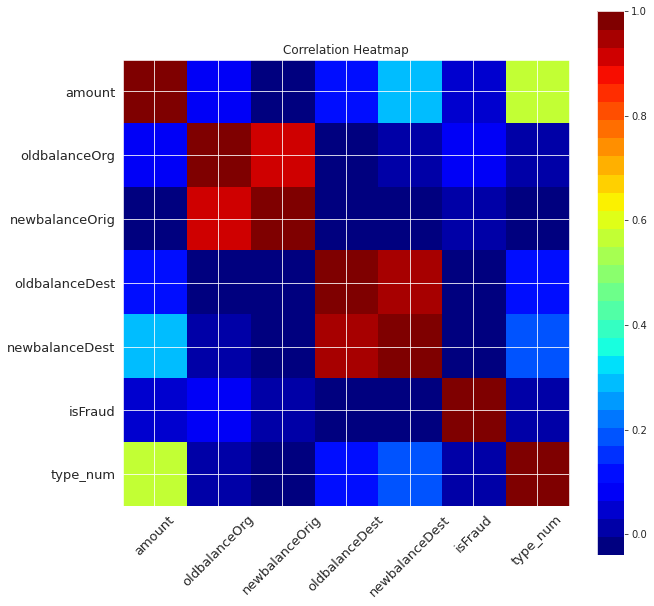

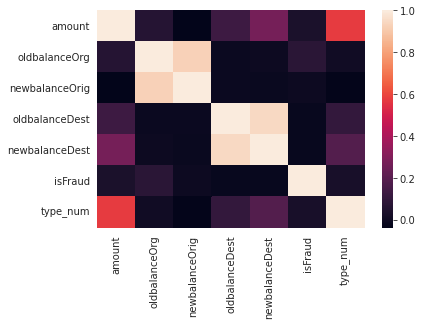

In [44]:
def correlation_plot(df):
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation = "nearest", cmap = cmap)
    ax1.grid(True)
    plt.title("Correlation Heatmap")
    labels = df.columns.tolist()
    ax1.set_xticklabels(labels, fontsize=13, rotation=45)
    ax1.set_yticklabels(labels, fontsize=13)
    fig.colorbar(cax)
    plt.show()
    
correlation_plot(tmp)

# Alternatively, we can use quick seaborn
# plot the heatmap
sns.heatmap(tmp.corr())


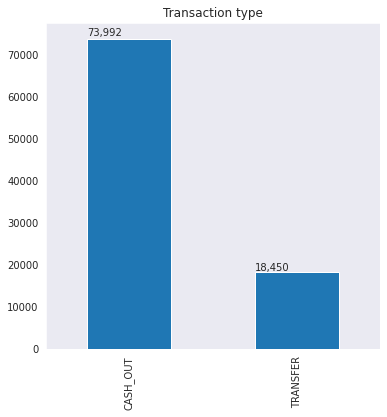

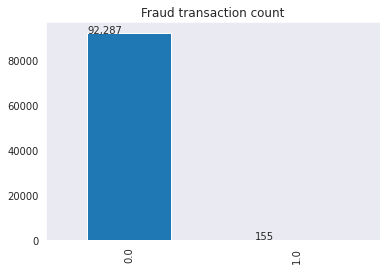

In [45]:
ax = tmp.type.value_counts().plot(kind='bar', title="Transaction type", figsize=(6,6))
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

plt.show()

ax = pd.value_counts(tmp['isFraud'], sort = True).sort_index().plot(kind='bar', title="Fraud transaction count")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))
    
plt.show()

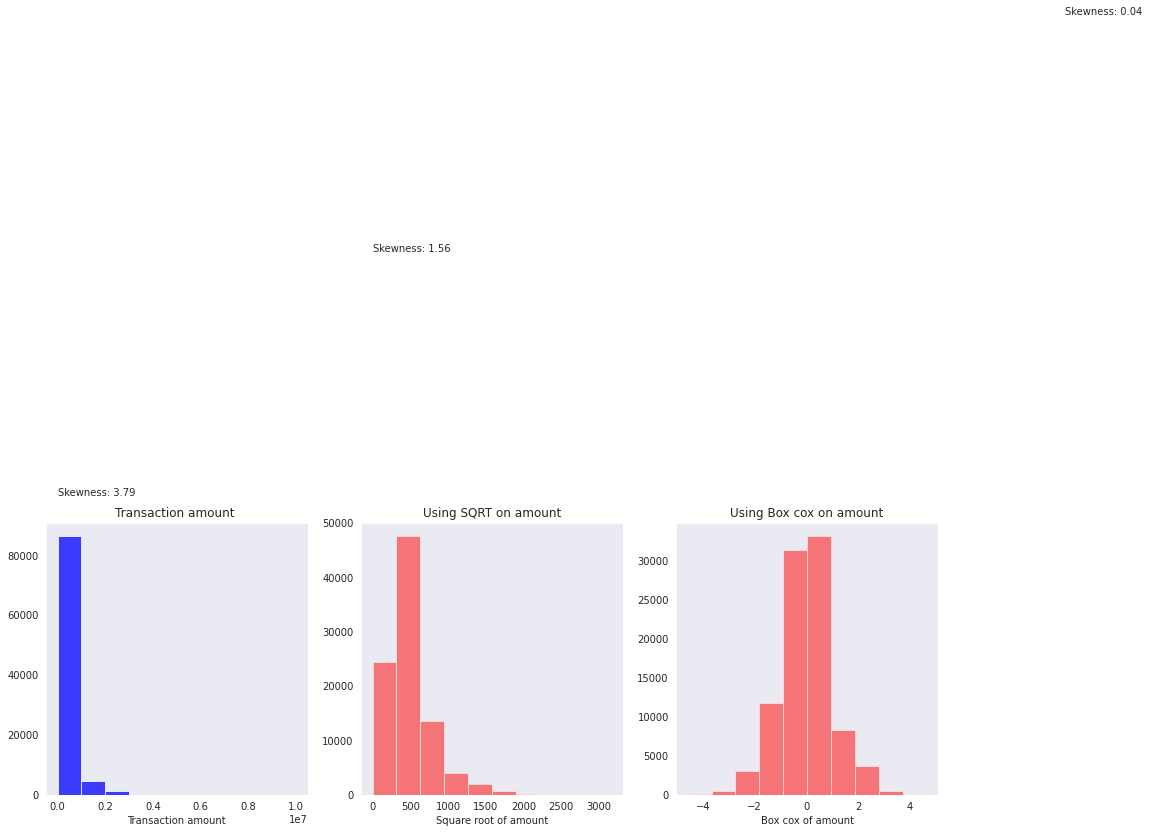

In [46]:
tmp['amount_boxcox'] = preprocessing.scale(boxcox(tmp['amount']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['amount'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("Transaction amount") 
plt.title("Transaction amount ") 
plt.text(10,100000,"Skewness: {0:.2f}".format(skew(tmp['amount'])))

figure.add_subplot(132)
plt.hist(np.sqrt(tmp['amount']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of amount")
plt.title("Using SQRT on amount")
plt.text(10, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['amount']))))

figure.add_subplot(133)
plt.hist(tmp['amount_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of amount")
plt.title("Using Box cox on amount")
plt.text(10, 100000, "Skewness: {0:.2f}".format(skew(tmp['amount_boxcox'])))

plt.show()

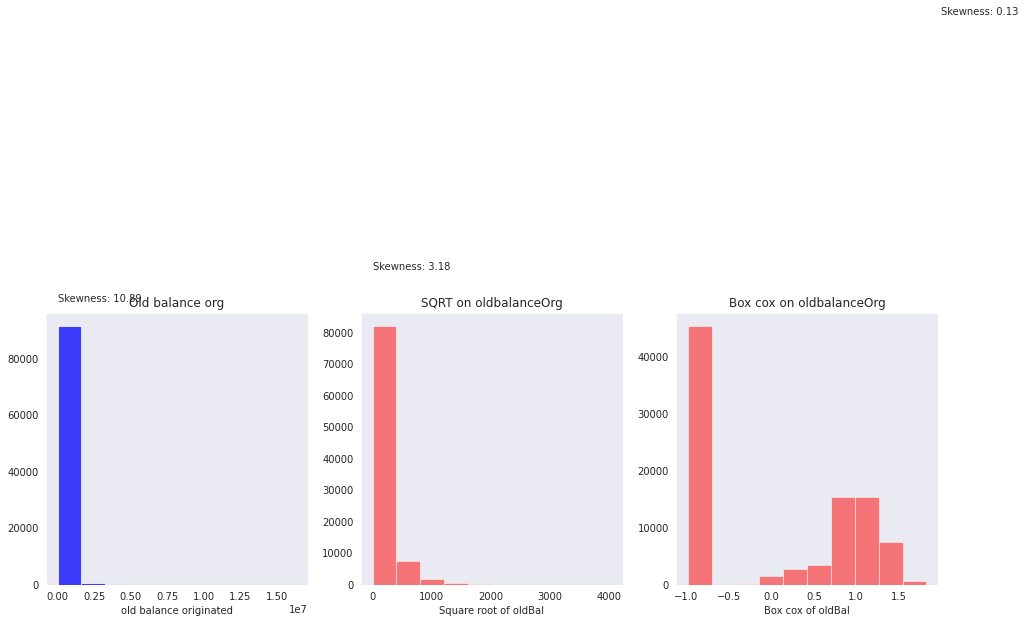

In [47]:
tmp['oldbalanceOrg_boxcox'] = preprocessing.scale(boxcox(tmp['oldbalanceOrg']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['oldbalanceOrg'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("old balance originated") 
plt.title("Old balance org") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['oldbalanceOrg'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['oldbalanceOrg']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of oldBal")
plt.title("SQRT on oldbalanceOrg")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['oldbalanceOrg']))))

figure.add_subplot(133)
plt.hist(tmp['oldbalanceOrg_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of oldBal")
plt.title("Box cox on oldbalanceOrg")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['oldbalanceOrg_boxcox'])))

plt.show()

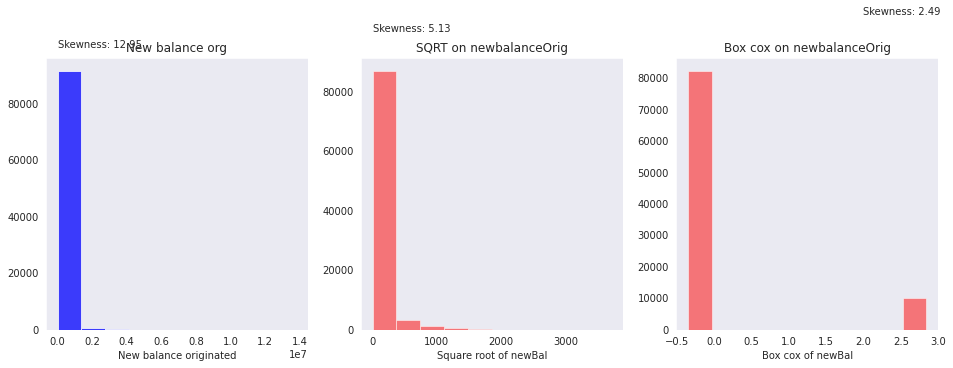

In [48]:
tmp['newbalanceOrg_boxcox'] = preprocessing.scale(boxcox(tmp['newbalanceOrig']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['newbalanceOrig'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("New balance originated") 
plt.title("New balance org") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['newbalanceOrig'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['newbalanceOrig']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of newBal")
plt.title("SQRT on newbalanceOrig")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['newbalanceOrig']))))

figure.add_subplot(133)
plt.hist(tmp['newbalanceOrg_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of newBal")
plt.title("Box cox on newbalanceOrig")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['newbalanceOrg_boxcox'])))

plt.show()

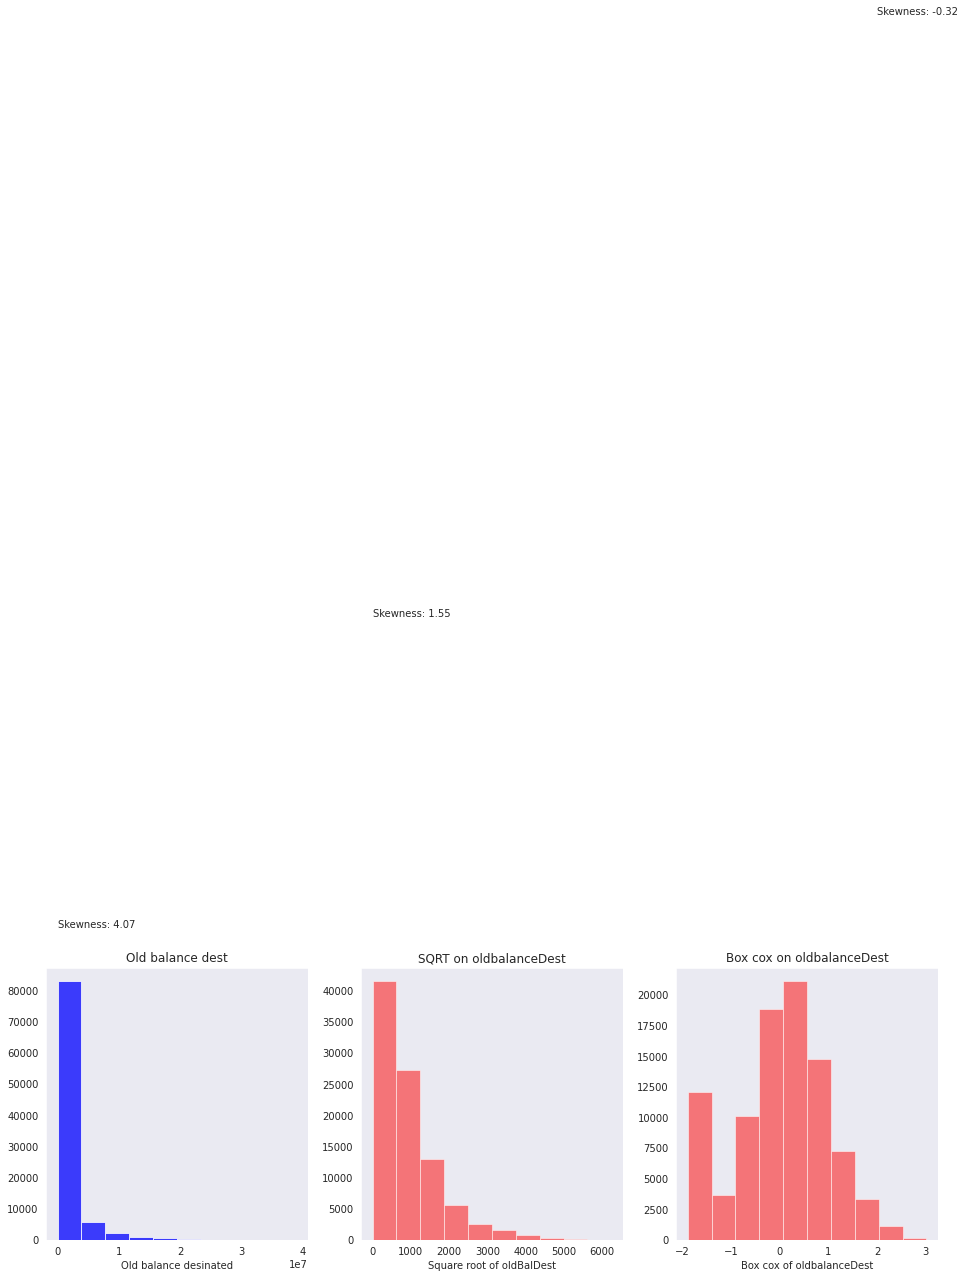

In [49]:
tmp['oldbalanceDest_boxcox'] = preprocessing.scale(boxcox(tmp['oldbalanceDest']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['oldbalanceDest'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("Old balance desinated") 
plt.title("Old balance dest") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['oldbalanceDest'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['oldbalanceDest']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of oldBalDest")
plt.title("SQRT on oldbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['oldbalanceDest']))))

figure.add_subplot(133)
plt.hist(tmp['oldbalanceDest_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of oldbalanceDest")
plt.title("Box cox on oldbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['oldbalanceDest_boxcox'])))

plt.show()


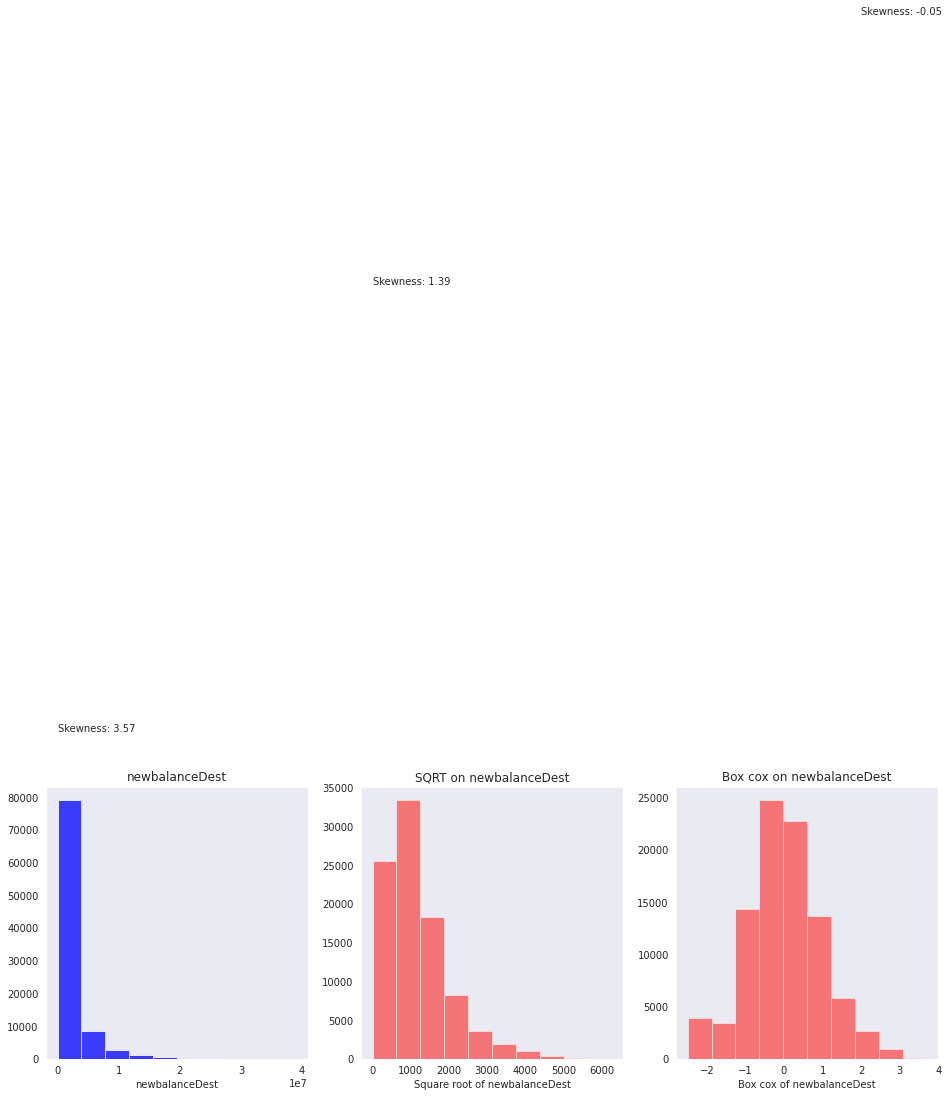

In [50]:
tmp['newbalanceDest_boxcox'] = preprocessing.scale(boxcox(tmp['newbalanceDest']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['newbalanceDest'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("newbalanceDest") 
plt.title("newbalanceDest") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['newbalanceDest'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['newbalanceDest']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of newbalanceDest")
plt.title("SQRT on newbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['newbalanceDest']))))

figure.add_subplot(133)
plt.hist(tmp['newbalanceDest_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of newbalanceDest")
plt.title("Box cox on newbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['newbalanceDest_boxcox'])))

plt.show()


In [51]:
print("The fraud transaction of the filtered dataset: {0:.4f}%".format((len(tmp[tmp.isFraud == 1])/len(tmp)) * 100))

The fraud transaction of the filtered dataset: 0.1677%


In [53]:
# Here we perform an initial separation of the data, specifically the target column from the rest of the columns.
target=df["isFraud"]
features=df.drop(["isFraud",'nameOrig','type','nameDest'],axis=1)

In [54]:
from sklearn.preprocessing import LabelEncoder
# Here I made a transformation of the target column.
object_1=LabelEncoder()
y=object_1.fit_transform(target)

In [55]:
# Here I do a conversion of categorical columns from the data
object_1=LabelEncoder()
# During the conversion process, we used the first projection.
for i in features.select_dtypes(exclude=[np.number]).columns:
    features[i] = object_1.fit_transform(df[i])

In [56]:
print(features.shape)

(219765, 7)


In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(features)

MinMaxScaler()

In [58]:
new_features = scaler.transform(features)
print(new_features)

[[0.00000000e+00 9.83934030e-04 4.36924799e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86398006e-04 5.45693742e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.80700005e-05 4.64824544e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.00000000e+00 1.44258374e-02 7.66606100e-03 ... 2.28344980e-02
  1.91378871e-02 0.00000000e+00]
 [1.00000000e+00 3.48453180e-02 3.05448791e-04 ... 9.55453185e-03
  1.84788051e-02 0.00000000e+00]
 [1.00000000e+00 3.89812812e-03 2.82490054e-07 ...            nan
             nan            nan]]


# XGB Classifier

In [72]:
# Complete the data separation. 
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(new_features,y,test_size=0.1,random_state=1)

In [73]:
from xgboost import XGBClassifier
from sklearn import metrics

In [74]:
# Creating model object
model_xgb = XGBClassifier()
model_xgb.fit(x_train, y_train)

XGBClassifier(objective='multi:softprob')

In [75]:
print('model_xgb Train Score is : ' , model_xgb.score(x_train, y_train))
print('model_xgb Test Score is : ' , model_xgb.score(x_test, y_test))

model_xgb Train Score is :  0.9994741844803527
model_xgb Test Score is :  0.999408472493971


### predict

In [76]:
pred_xgb= model_xgb.predict(x_test)

### Confusion Matrix

In [77]:
confusion_matrix=confusion_matrix(y_test,pred_xgb)
confusion_matrix

array([[21960,     1],
       [   12,     4]])

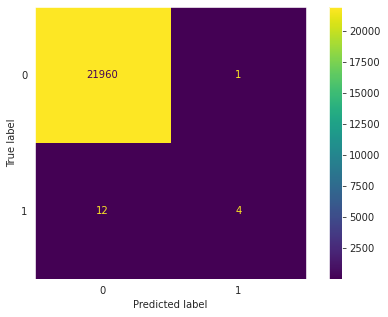

In [78]:
import matplotlib
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix
matplotlib.rcParams['figure.figsize'] = (8,5)
plot_confusion_matrix(model_xgb,x_test,y_test);